# Time Series Classification for Activity Recognition

Classify human activities (bending, cycling, lying, sitting, standing, walking) from wearable sensor time series using the **AReM** (Activity Recognition with Ambient Sensing) dataset. This notebook covers:

- **Feature extraction** — Statistical aggregation (mean, median, std, quartiles) from raw sensor streams
- **Binary classification** — Bending vs. other activities (Logistic Regression + RFE, L1-penalized)
- **Multi-class classification** — All 7 activity classes (L1 multinomial, Gaussian NB, Multinomial NB)

*UCI Dataset: [AReM - Activity Recognition (Multisensor data fusion)](https://archive.ics.uci.edu/dataset/366/activity+recognition+system+based+on+multisensor+data+fusion+arem)*

---
## 1. Feature Creation & Extraction

Load the AReM dataset, split into train/test sets, and extract statistical features (central tendency, dispersion, quartiles) from each time series file.

### Setup & Load Data

In [1]:
import warnings
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import label_binarize
import statsmodels.api as sm
from itertools import cycle

warnings.filterwarnings('ignore')

# data path: works when running from project root (recommended) or from notebooks/
_data_paths = ["data/AReM", "../data/AReM"]
DATA_PATH = next((p + "/" for p in _data_paths if os.path.exists(p)), None)
if DATA_PATH is None:
    raise FileNotFoundError("AReM data not found. Run Jupyter from project root (see README).")

### Train/Test Split

Bending activities use datasets 1–2 for test; other activities use 1–3 for test.

In [2]:
train_files = []
test_files = []

for folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, folder)
    if not os.path.isdir(folder_path):
        continue
    
    for file in os.listdir(folder_path):
        if file.startswith("dataset"):
            file_path = os.path.join(folder_path, file)
            num = int(re.findall(r"\d+", file)[0])
            
            # test data: 1-2 for bending folders, 1-3 for others
            if (folder in ['bending1', 'bending2'] and num <= 2) or \
               (folder not in ['bending1', 'bending2'] and num <= 3):
                test_files.append(file_path)
            else:
                train_files.append(file_path)

### Feature Extraction

We extract per-sensor statistics: **central tendency** (mean, median), **dispersion** (min, max, std), and **position** (Q1, Q3).

**Feature categories:**

*Measures of Central Tendency*
- mean
- median

*Measures of Dispersion*
- minimum
- maximum
- standard deviation
- variance

*Measures of Position*
- first quartile 
- third quartile
- interquartile range

**Extract features from each time series file:**

In [3]:
def load_file(filepath):
    with open(filepath, 'r') as f:
        data = []
        for line in f:
            line = line.strip()
            if line and not line.startswith('@'):
                vals = line.replace(',', ' ').split()
                # skip timestamp if present
                if len(vals) == 7:
                    vals = vals[1:]
                if len(vals) == 6:
                    data.append([float(v) for v in vals])
    return pd.DataFrame(data)

def get_features(df):
    features = {}
    for i in range(len(df.columns)):
        col = df.iloc[:, i]
        features[f'min_{i+1}'] = col.min()
        features[f'max_{i+1}'] = col.max()
        features[f'mean_{i+1}'] = col.mean()
        features[f'median_{i+1}'] = col.median()
        features[f'std_{i+1}'] = col.std()
        features[f'q1_{i+1}'] = col.quantile(0.25)
        features[f'q3_{i+1}'] = col.quantile(0.75)
    return features

# extract features from train files
train_data = []
for file in train_files:
    df = load_file(file)
    feats = get_features(df)
    feats['activity'] = os.path.basename(os.path.dirname(file))
    train_data.append(feats)

# extract features from test files
test_data = []
for file in test_files:
    df = load_file(file)
    feats = get_features(df)
    feats['activity'] = os.path.basename(os.path.dirname(file))
    test_data.append(feats)

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (69, 43)
Test shape: (19, 43)


,min_1,max_1,mean_1,median_1,std_1,q1_1,q3_1,min_2,max_2,mean_2,...,q1_5,q3_5,min_6,max_6,mean_6,median_6,std_6,q1_6,q3_6,activity
0,36.25,48.00,43.969125,44.50,1.618364,43.31,44.67,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555312,0.49,0.487826,0.00,0.83,bending1
1,37.00,48.00,43.454958,43.25,1.386098,42.50,45.00,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.50,0.622534,0.43,0.87,bending1
2,33.00,47.75,42.179812,43.50,3.670666,39.15,45.00,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.50,0.524317,0.00,1.00,bending1
3,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.43,0.389164,0.00,0.50,bending1
4,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.43,0.513506,0.00,0.94,bending1


### Bootstrap Confidence Intervals (90%)


In [4]:
# bootstrap confidence intervals for std dev
results = []
features = [col for col in train_df.columns if col != 'activity']

for feat in features:
    data = train_df[feat].values
    std = np.std(data, ddof=1)
    
    ci = bootstrap(
        (data,),
        statistic=lambda x: np.std(x, ddof=1),
        confidence_level=0.90,
        random_state=42
    )
    
    results.append({
        'Feature': feat,
        'Std': std,
        'CI_Lower': ci.confidence_interval.low,
        'CI_Upper': ci.confidence_interval.high
    })

ci_df = pd.DataFrame(results)
ci_df.round(4)

,Feature,Std,CI_Lower,CI_Upper
0,min_1,8.7943,7.8564,10.7701
1,max_1,4.4292,3.5418,5.7619
2,mean_1,4.9177,4.4421,5.5853
3,median_1,4.9561,4.4481,5.6521
4,std_1,1.7586,1.5918,2.0080
5,q1_1,5.7313,5.2610,6.3302
6,q3_1,4.7836,4.1032,5.7798
7,min_2,0.0000,NaN,NaN
8,max_2,5.1478,4.7503,5.6081
9,mean_2,1.6007,1.4303,1.7617


### Key Discriminative Features


**Key features for distinguishing activities:**

- **Mean**: Shows a notable difference in central tendency between bending activities vs sitting and walking.

- **Maximum**: Captures peak sensor readings characteristic of dynamic movements like walking.

- **Standard Deviation**: Reflects variability of sensor readings; motion-heavy activities show larger variability than static ones.


---

Train and evaluate binary (bending vs. other) and multi-class (all 6 activities) classifiers.


In [5]:
def build_segmented_features(file_list, l=1):
    """build features for time series classification by segmenting each time series into l segments"""
    all_features = []
    
    for file_path in file_list:
        df = load_file(file_path)
        if df.empty or len(df) < l:
            continue
            
        activity = os.path.basename(os.path.dirname(file_path))
        n_rows = len(df)
        segment_size = n_rows // l
        
        for seg_idx in range(l):
            start_idx = seg_idx * segment_size
            if seg_idx == l - 1:
                end_idx = n_rows
            else:
                end_idx = (seg_idx + 1) * segment_size
            
            segment_df = df.iloc[start_idx:end_idx]
            if len(segment_df) < 2:
                continue
            
            features = get_features(segment_df)
            segment_features = {}
            for key, value in features.items():
                if pd.isna(value) or np.isnan(value):
                    value = 0.0
                segment_features[f"{key}_seg{seg_idx + 1}"] = value
            
            segment_features['activity'] = activity
            all_features.append(segment_features)
    
    result_df = pd.DataFrame(all_features)
    return result_df.fillna(0.0)



## 2. Binary Classification (Bending vs. Other)


### Feature Scatter Plots


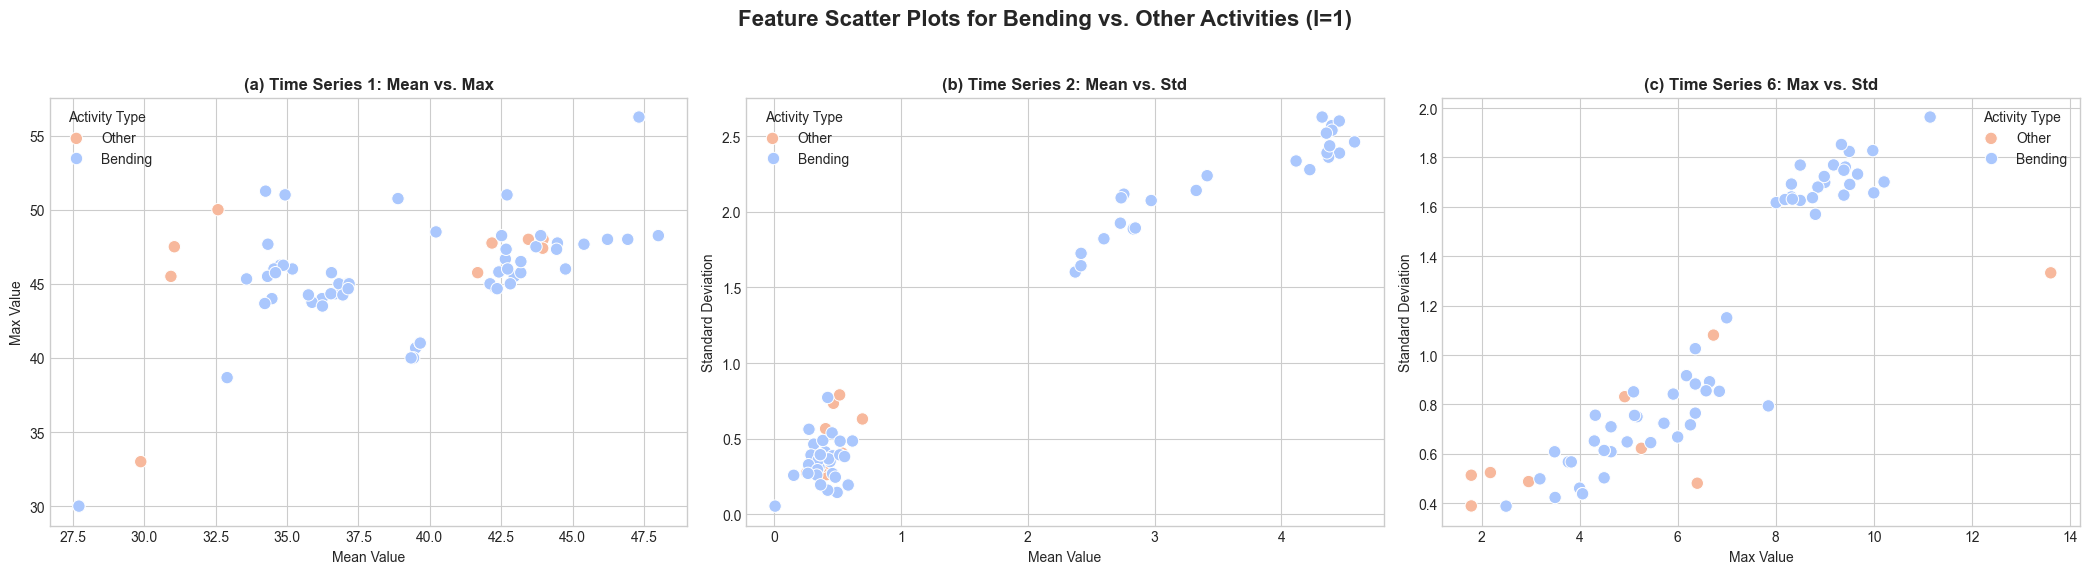

In [6]:
# build features for l=1 (no segmentation)
train_features_df = build_segmented_features(train_files, l=1)
test_features_df = build_segmented_features(test_files, l=1)

# 1 for bending, 0 otherwise
# the 'activity' column contains labels like 'bending1', 'bending2', etc.
train_features_df['is_bending'] = train_features_df['activity'].str.contains('bending').astype(int)
test_features_df['is_bending'] = test_features_df['activity'].str.contains('bending').astype(int)

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle('Feature Scatter Plots for Bending vs. Other Activities (l=1)', fontsize=16, fontweight='bold')

sns.scatterplot(ax=axes[0], data=train_features_df, x='mean_1_seg1', y='max_1_seg1', hue='is_bending', palette='coolwarm', s=80)
axes[0].set_title('(a) Time Series 1: Mean vs. Max', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Mean Value', fontsize=10)
axes[0].set_ylabel('Max Value', fontsize=10)
axes[0].legend(title='Activity Type', labels=['Other', 'Bending'])

sns.scatterplot(ax=axes[1], data=train_features_df, x='mean_2_seg1', y='std_2_seg1', hue='is_bending', palette='coolwarm', s=80)
axes[1].set_title('(b) Time Series 2: Mean vs. Std', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean Value', fontsize=10)
axes[1].set_ylabel('Standard Deviation', fontsize=10)
axes[1].legend(title='Activity Type', labels=['Other', 'Bending'])

sns.scatterplot(ax=axes[2], data=train_features_df, x='max_6_seg1', y='std_6_seg1', hue='is_bending', palette='coolwarm', s=80)
axes[2].set_title('(c) Time Series 6: Max vs. Std', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Max Value', fontsize=10)
axes[2].set_ylabel('Standard Deviation', fontsize=10)
axes[2].legend(title='Activity Type', labels=['Other', 'Bending'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Segmented Features (l=2)


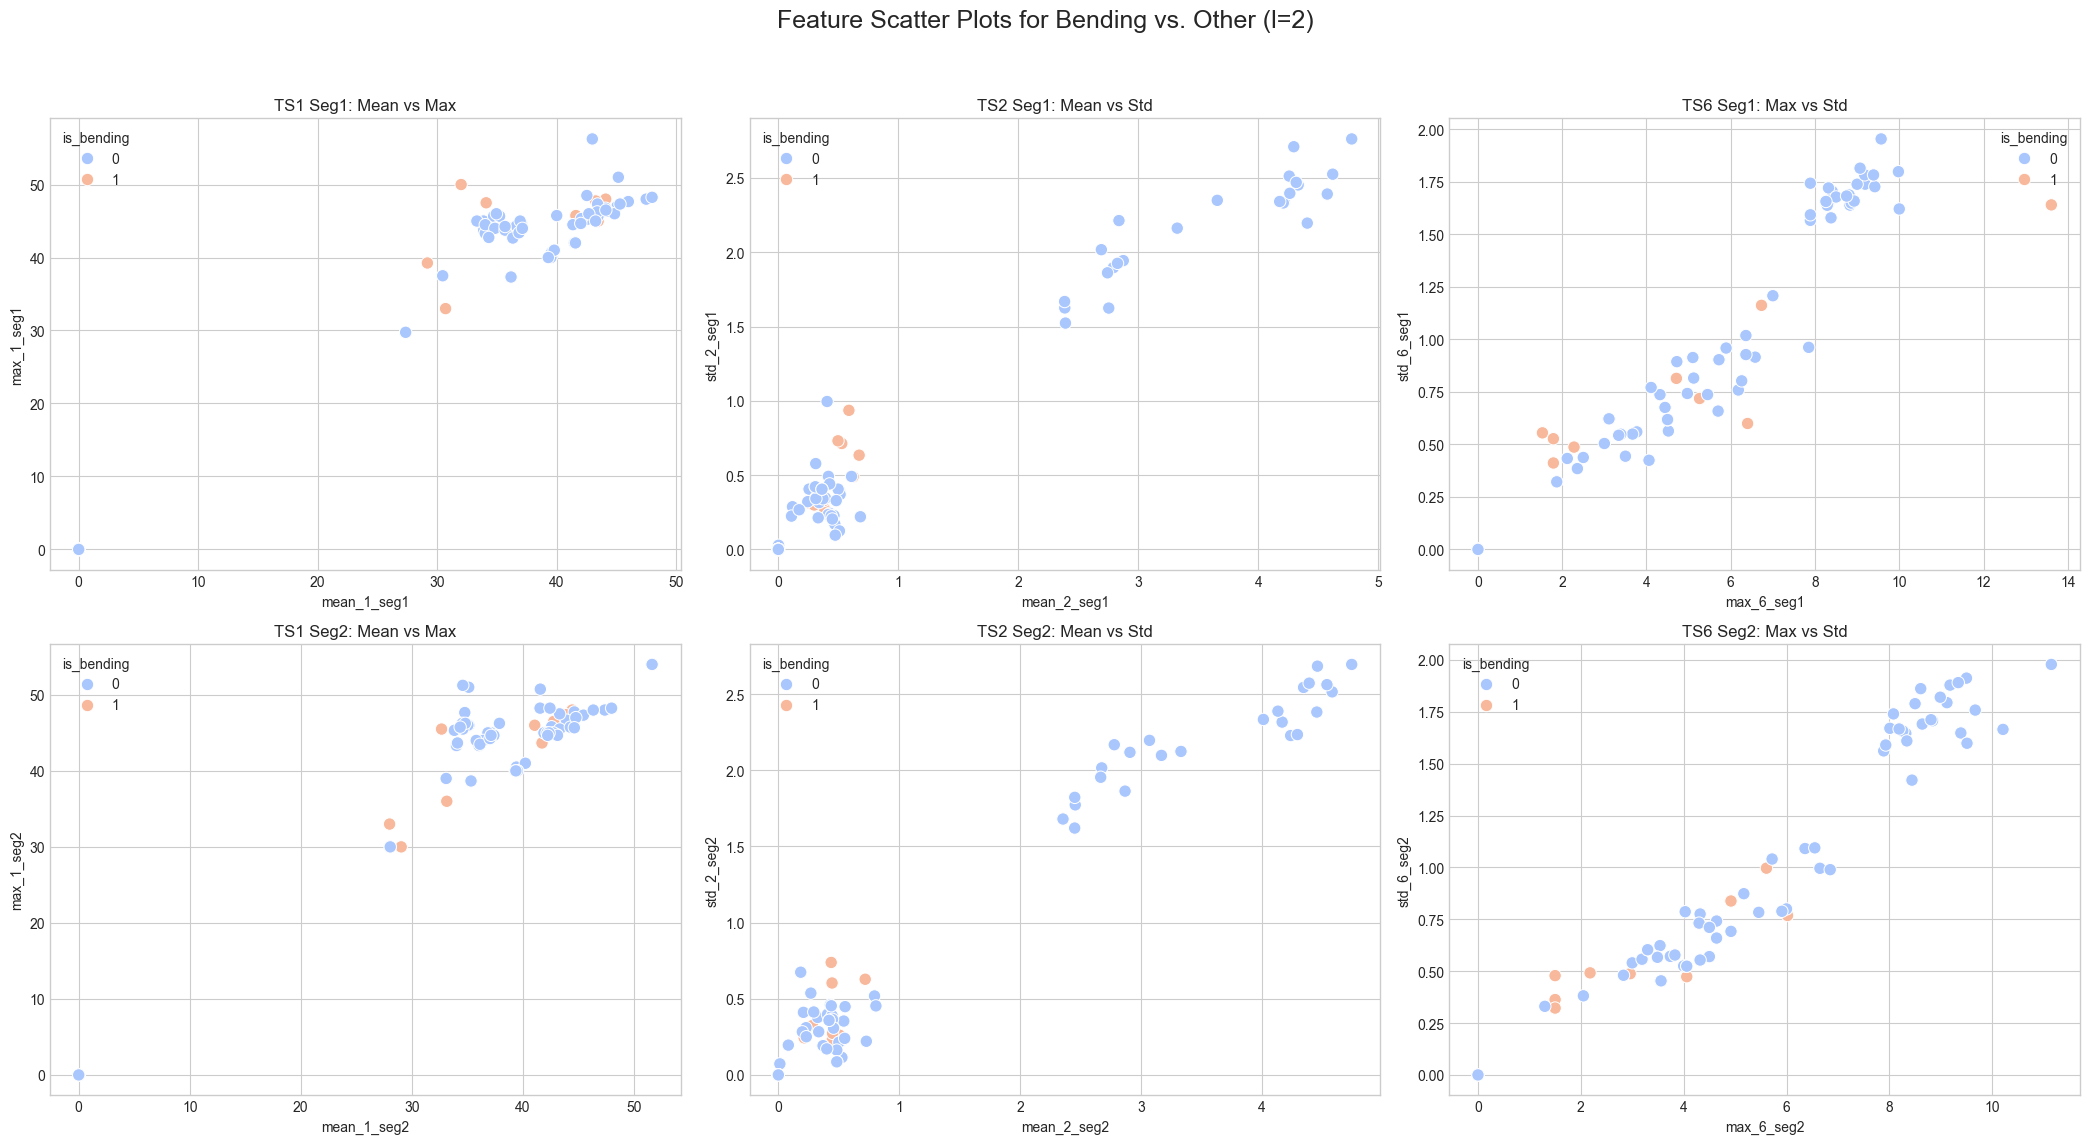

In [7]:
# feature set for l=2
train_features_l2 = build_segmented_features(train_files, l=2)
train_features_l2['is_bending'] = train_features_l2['activity'].str.contains('bending').astype(int)

# scatter plots for l=2
fig, axes = plt.subplots(2, 3, figsize=(21, 12))
fig.suptitle('Feature Scatter Plots for Bending vs. Other (l=2)', fontsize=18)

sns.scatterplot(ax=axes[0, 0], data=train_features_l2, x='mean_1_seg1', y='max_1_seg1', hue='is_bending', palette='coolwarm', s=80).set_title('TS1 Seg1: Mean vs Max')
sns.scatterplot(ax=axes[0, 1], data=train_features_l2, x='mean_2_seg1', y='std_2_seg1', hue='is_bending', palette='coolwarm', s=80).set_title('TS2 Seg1: Mean vs Std')
sns.scatterplot(ax=axes[0, 2], data=train_features_l2, x='max_6_seg1', y='std_6_seg1', hue='is_bending', palette='coolwarm', s=80).set_title('TS6 Seg1: Max vs Std')

sns.scatterplot(ax=axes[1, 0], data=train_features_l2, x='mean_1_seg2', y='max_1_seg2', hue='is_bending', palette='coolwarm', s=80).set_title('TS1 Seg2: Mean vs Max')
sns.scatterplot(ax=axes[1, 1], data=train_features_l2, x='mean_2_seg2', y='std_2_seg2', hue='is_bending', palette='coolwarm', s=80).set_title('TS2 Seg2: Mean vs Std')
sns.scatterplot(ax=axes[1, 2], data=train_features_l2, x='max_6_seg2', y='std_6_seg2', hue='is_bending', palette='coolwarm', s=80).set_title('TS6 Seg2: Max vs Std')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Splitting each time series into two parts did not produce a considerable difference in the scatter plots.

### Optimal Segment Count (l) via RFECV


Testing l = 1...
  Best score for l=1 is 0.9857 with p=5 features.
Testing l = 2...
  Best score for l=2 is 0.9638 with p=53 features.
Testing l = 3...
  Best score for l=3 is 0.9035 with p=5 features.
Testing l = 4...
  Best score for l=4 is 0.9131 with p=82 features.
Testing l = 5...
  Best score for l=5 is 0.9130 with p=22 features.
Testing l = 6...
  Best score for l=6 is 0.9106 with p=82 features.
Testing l = 7...
  Best score for l=7 is 0.9089 with p=109 features.
Testing l = 8...
  Best score for l=8 is 0.9039 with p=168 features.
Testing l = 9...
  Best score for l=9 is 0.9195 with p=77 features.
Testing l = 10...
  Best score for l=10 is 0.8942 with p=108 features.
Testing l = 11...
  Best score for l=11 is 0.8828 with p=111 features.
Testing l = 12...
  Best score for l=12 is 0.8877 with p=114 features.
Testing l = 13...
  Best score for l=13 is 0.8941 with p=326 features.
Testing l = 14...
  Best score for l=14 is 0.8934 with p=214 features.
Testing l = 15...
  Best score fo

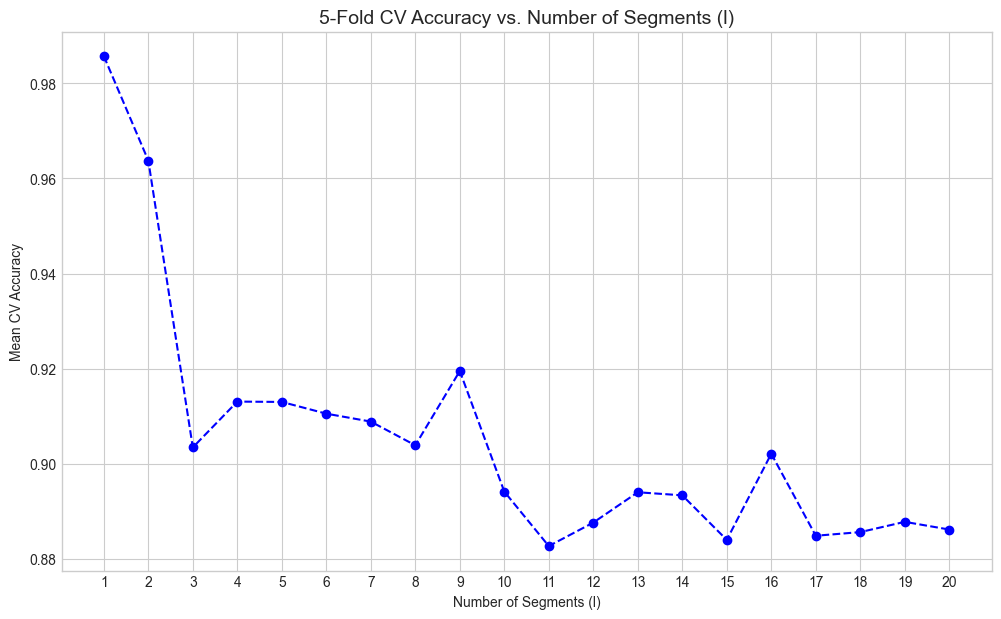

In [8]:
best_l = -1
best_p = -1
best_score = -1
l_scores = []

# remove l2 regularization by setting c to very large value
log_reg = LogisticRegression(solver='liblinear', C=1e10, max_iter=2000)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# loop over l = 1 to 20
for l in range(1, 21):
    print(f"Testing l = {l}...")
    # build features with l segments per time series
    df_train = build_segmented_features(train_files, l=l)
    y_train = df_train['activity'].str.contains('bending').astype(int)
    X_train = df_train.drop(columns=['activity'])
    
    # check for class imbalance and use stratified cv
    if len(np.unique(y_train)) < 2:
        print(f"  Skipping l={l} - only one class present")
        l_scores.append(0)
        continue
        
    # standardize features to avoid numerical issues
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # use a more efficient approach for larger feature sets
    if X_train.shape[1] > 200:
        # for large feature sets, use a step size > 1 to speed up rfecv
        step_size = max(1, X_train.shape[1] // 50)
        rfecv = RFECV(
            estimator=log_reg,
            step=step_size,
            cv=cv_strategy,
            scoring='accuracy',
            min_features_to_select=1
        )
    else:
        rfecv = RFECV(
            estimator=log_reg,
            step=1,
            cv=cv_strategy,
            scoring='accuracy',
            min_features_to_select=1
        )
    
    rfecv.fit(X_train_scaled, y_train)
    # best score for the optimal number of features
    current_best_score = np.max(rfecv.cv_results_['mean_test_score'])
    current_p = rfecv.n_features_
    l_scores.append(current_best_score)
    print(f"  Best score for l={l} is {current_best_score:.4f} with p={current_p} features.")

    if current_best_score > best_score:
        best_score = current_best_score
        best_l = l
        best_p = current_p

print(f"\nOptimal (l, p): ({best_l}, {best_p}) with CV Accuracy: {best_score:.4f}")

plt.figure(figsize=(12, 7))
plt.plot(range(1, 21), l_scores, marker='o', linestyle='--', color='b')
plt.title('5-Fold CV Accuracy vs. Number of Segments (l)', fontsize=14)
plt.xlabel('Number of Segments (l)')
plt.ylabel('Mean CV Accuracy')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

### Confusion Matrix & ROC


Selected 5 features:
['q3_1_seg1', 'max_4_seg1', 'min_5_seg1', 'max_5_seg1', 'q1_6_seg1']
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
                           Logit Regression Results                           
Dep. Variable:               activity   No. Observations:                   69
Model:                          Logit   Df Residuals:                       63
Method:                           MLE   Df Model:                            5
Date:                Mon, 20 Oct 2025   Pseudo R-squ.:                   1.000
Time:                        16:42:13   Log-Likelihood:            -0.00048854
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.739e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

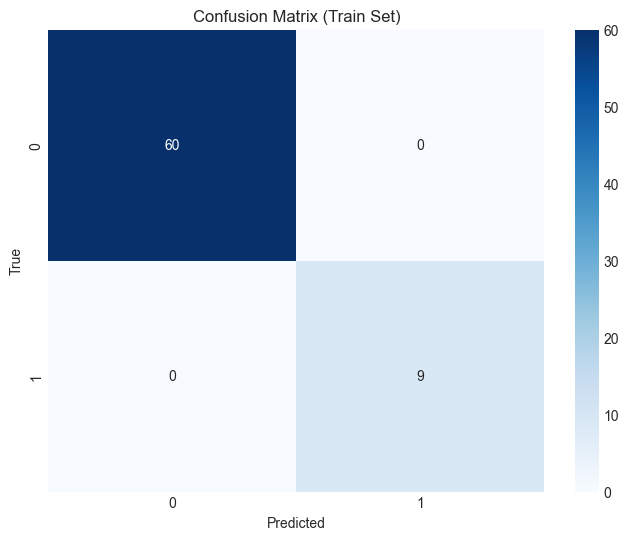

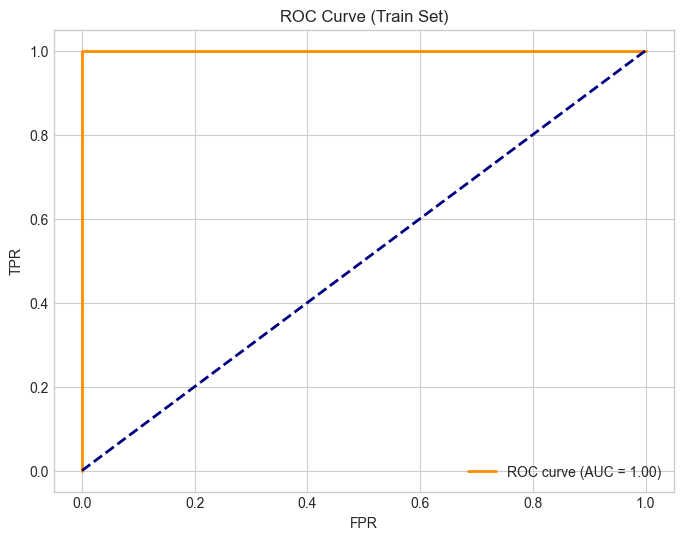

In [ ]:
# create the final training dataset using optimal l
df_train_final = build_segmented_features(train_files, l=best_l)
y_train_final = df_train_final['activity'].str.contains('bending').astype(int)
X_train_final = df_train_final.drop(columns=['activity'])

# standardize features
scaler_final = StandardScaler()
X_train_final_scaled = scaler_final.fit_transform(X_train_final)

# select the best_p features using rfe
rfe = RFE(estimator=log_reg, n_features_to_select=best_p)
rfe.fit(X_train_final_scaled, y_train_final)
selected_features = X_train_final.columns[rfe.support_]
X_train_pruned = X_train_final_scaled[:, rfe.support_]
print(f"Selected {len(selected_features)} features:\n{selected_features.tolist()}")

# get p-values using statsmodels
logit_model = sm.Logit(y_train_final, sm.add_constant(X_train_pruned)).fit(method='bfgs', maxiter=1000)
print(logit_model.summary())

# metrics - remove L2 regularization
final_model = LogisticRegression(solver='liblinear', C=1e10).fit(X_train_pruned, y_train_final)
y_train_proba = final_model.predict_proba(X_train_pruned)[:, 1]

# confusion matrix, roc, and auc
cm_train = confusion_matrix(y_train_final, final_model.predict(X_train_pruned))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Train Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

fpr, tpr, _ = roc_curve(y_train_final, y_train_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve (Train Set)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.show()

### Test Set Evaluation


Best Cross-Validation Accuracy: 0.9857
Test Set Accuracy: 1.0000


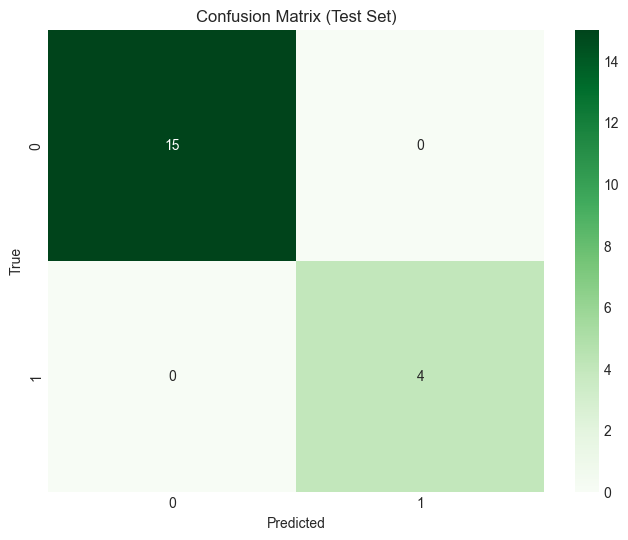

In [10]:
# create test dataset
df_test_final = build_segmented_features(test_files, l=best_l)
y_test_final = df_test_final['activity'].str.contains('bending').astype(int)
X_test_final = df_test_final.drop(columns=['activity'])

# standardize test features using the same scaler
X_test_final_scaled = scaler_final.transform(X_test_final)
X_test_pruned = X_test_final_scaled[:, rfe.support_]

# make predictions and calculate accuracy
y_test_pred = final_model.predict(X_test_pruned)
test_accuracy = (y_test_pred == y_test_final).mean()

print(f"Best Cross-Validation Accuracy: {best_score:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# confusion matrix
cm_test = confusion_matrix(y_test_final, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Cross-validation setup:** For each *l*, we use RFECV so that feature selection is performed within each fold using only training data, preventing data leakage and giving unbiased performance estimates.


### Class Separability


Yes, the classes appear to be **well-separated**. The initial scatter plots showed a distinct cluster for the "bending" activity, and the logistic regression model achieved a perfect **AUC of 1.0** on the training set. This high degree of separability can lead to **instability**, or quasi-complete separation. When this happens, the algorithm struggles to find a finite maximum for the model coefficients, which can lead to convergence warnings or extremely large parameter estimates. 

**Class imbalance:** The confusion matrix shows fewer bending instances than other activities. We address this with case-control sampling and intercept adjustment.


The confusion matrix shows the classes are **imbalanced**, with fewer "bending" instances than "other" instances.

Accuracy with Case-Control Adjustment: 1.0000


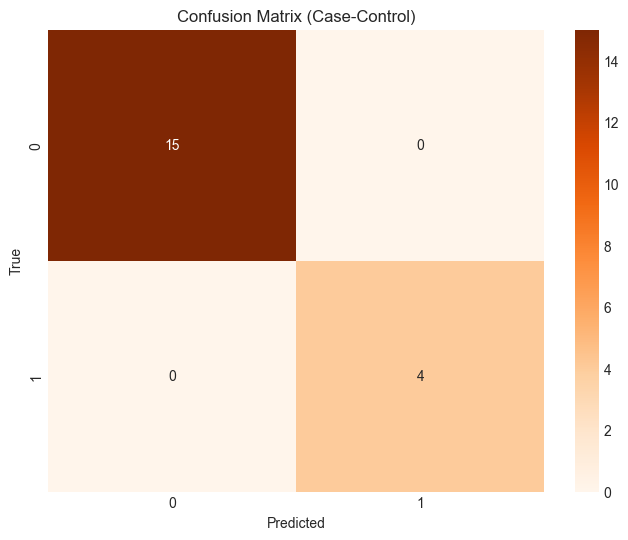

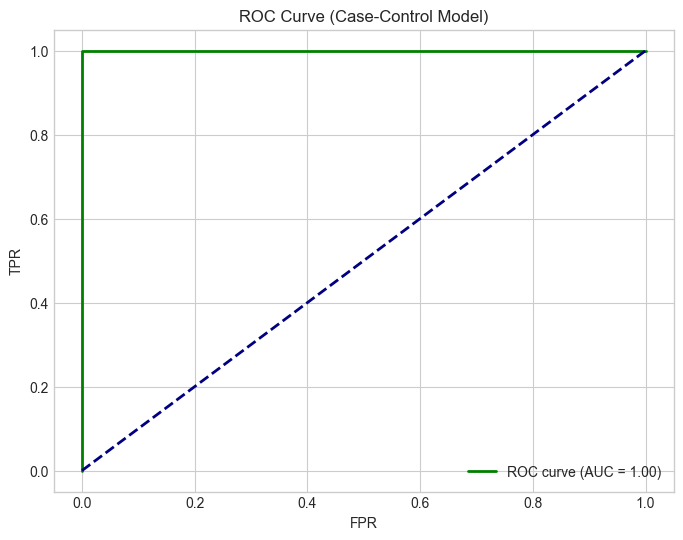

In [ ]:
# create a balanced training set using the pruned features
bending_indices = np.where(y_train_final == 1)[0]
other_indices = np.where(y_train_final == 0)[0]

# sample equal number of other class instances
np.random.seed(42)
other_sampled_indices = np.random.choice(other_indices, size=len(bending_indices), replace=False)
balanced_indices = np.concatenate([bending_indices, other_sampled_indices])

X_train_balanced = X_train_pruned[balanced_indices]
y_train_balanced = y_train_final.iloc[balanced_indices]

# train model - remove L2 regularization
cc_model = LogisticRegression(solver='liblinear', C=1e10).fit(X_train_balanced, y_train_balanced)

# adjust intercept
pi1 = y_train_final.mean() # proportion of cases in original population
tau1 = 0.5 # proportion of cases in the balanced sample
beta0_original = cc_model.intercept_[0]
beta0_adjusted = beta0_original + np.log(pi1/(1-pi1)) - np.log(tau1/(1-tau1))
cc_model.intercept_[0] = beta0_adjusted

y_test_pred_cc = cc_model.predict(X_test_pruned)
print(f"Accuracy with Case-Control Adjustment: {(y_test_pred_cc == y_test_final).mean():.4f}")

# confusion matrix, roc, and auc
cm_cc = confusion_matrix(y_test_final, y_test_pred_cc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cc, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix (Case-Control)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_test_proba_cc = cc_model.predict_proba(X_test_pruned)[:, 1]
fpr_cc, tpr_cc, _ = roc_curve(y_test_final, y_test_proba_cc)
roc_auc_cc = auc(fpr_cc, tpr_cc)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cc, tpr_cc, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_cc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve (Case-Control Model)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.show()

### L1-Penalized Logistic Regression


### Optimal (l, C) via GridSearchCV


In [ ]:
best_l_l1 = -1
best_c_l1 = -1
best_score_l1 = -1
cv_strategy_l1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# loop over l = 1 to 20
for l in range(1, 21):
    print(f"Testing l = {l} for L1 regression...")
    df_train = build_segmented_features(train_files, l=l)
    y_train = df_train['activity'].str.contains('bending').astype(int)
    X_train = df_train.drop(columns=['activity'])
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
    param_grid = {'C': np.logspace(-3, 3, 7)}
    
    grid_search = GridSearchCV(log_reg_l1, param_grid, cv=cv_strategy_l1, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)
    
    if grid_search.best_score_ > best_score_l1:
        best_score_l1, best_l_l1, best_c_l1 = grid_search.best_score_, l, grid_search.best_params_['C']

print(f"\nOptimal (l, C): ({best_l_l1}, {best_c_l1}) with CV Accuracy: {best_score_l1:.4f}")

Testing l = 1 for L1 regression...
Testing l = 2 for L1 regression...
Testing l = 3 for L1 regression...
Testing l = 4 for L1 regression...
Testing l = 5 for L1 regression...
Testing l = 6 for L1 regression...
Testing l = 7 for L1 regression...
Testing l = 8 for L1 regression...
Testing l = 9 for L1 regression...
Testing l = 10 for L1 regression...
Testing l = 11 for L1 regression...
Testing l = 12 for L1 regression...
Testing l = 13 for L1 regression...
Testing l = 14 for L1 regression...
Testing l = 15 for L1 regression...
Testing l = 16 for L1 regression...
Testing l = 17 for L1 regression...
Testing l = 18 for L1 regression...
Testing l = 19 for L1 regression...
Testing l = 20 for L1 regression...

Optimal (l, C): (1, 1.0) with CV Accuracy: 0.9857


### RFE vs L1 Comparison


In [13]:
print(f"RFE + p-value Method Test Accuracy: {test_accuracy:.4f}")

# create and scale final training set for l1 model
df_train_l1_final = build_segmented_features(train_files, l=best_l_l1)
y_train_l1_final = df_train_l1_final['activity'].str.contains('bending').astype(int)
X_train_l1_final = df_train_l1_final.drop(columns=['activity'])

final_scaler = StandardScaler().fit(X_train_l1_final)
X_train_l1_scaled = final_scaler.transform(X_train_l1_final)

# train final l1 model
final_l1_model = LogisticRegression(penalty='l1', C=best_c_l1, solver='liblinear').fit(X_train_l1_scaled, y_train_l1_final)

# prepare and scale the test set
df_test_l1 = build_segmented_features(test_files, l=best_l_l1)
y_test_l1 = df_test_l1['activity'].str.contains('bending').astype(int)
X_test_l1 = df_test_l1.drop(columns=['activity'])
X_test_l1_scaled = final_scaler.transform(X_test_l1)

# evaluate on test set
y_test_pred_l1 = final_l1_model.predict(X_test_l1_scaled)
accuracy_l1 = (y_test_pred_l1 == y_test_l1).mean()
print(f"L1-Penalized Method Test Accuracy: {accuracy_l1:.4f}")

RFE + p-value Method Test Accuracy: 1.0000
L1-Penalized Method Test Accuracy: 1.0000


Both methods performed exceptionally well, with identical and perfect test accuracies. However the L1-penalized method is easier to implement. It combines feature creation, scaling, and hyperparameter tuning into a single `GridSearchCV` pipeline. The RFE approach is more complex, requiring a custom loop for `l` and a separate `RFECV` step for `p`.

## 3. Multi-class Classification (All 7 Activity Classes)


### Optimal (l, C) for Multinomial


Testing l = 1 for multi-class...
Testing l = 2 for multi-class...
Testing l = 3 for multi-class...
Testing l = 4 for multi-class...
Testing l = 5 for multi-class...
Testing l = 6 for multi-class...
Testing l = 7 for multi-class...
Testing l = 8 for multi-class...
Testing l = 9 for multi-class...
Testing l = 10 for multi-class...
Testing l = 11 for multi-class...
Testing l = 12 for multi-class...
Testing l = 13 for multi-class...
Testing l = 14 for multi-class...
Testing l = 15 for multi-class...
Testing l = 16 for multi-class...
Testing l = 17 for multi-class...
Testing l = 18 for multi-class...
Testing l = 19 for multi-class...
Testing l = 20 for multi-class...

Optimal (l, C): (1, 1.0) with CV Accuracy: 0.9132
L1 Multinomial Regression Test Error: 0.1053


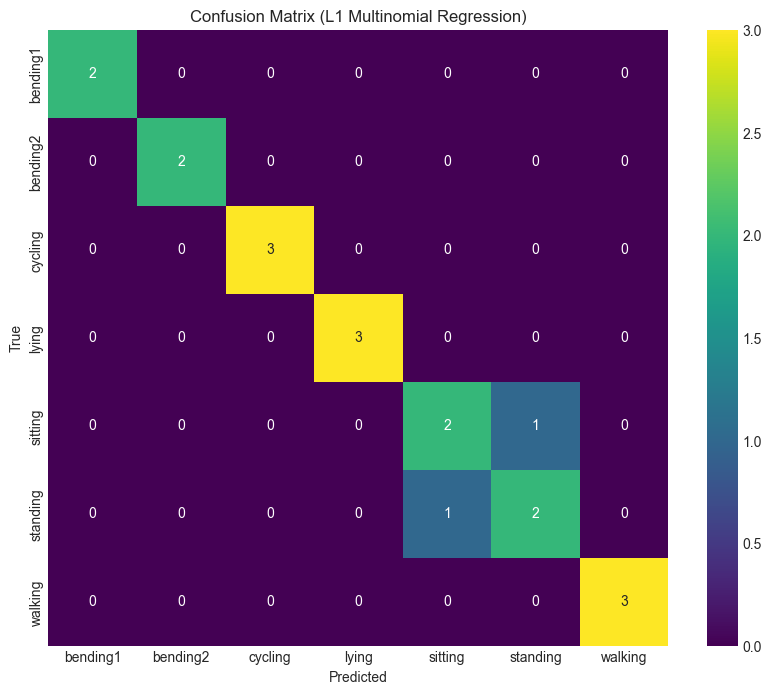

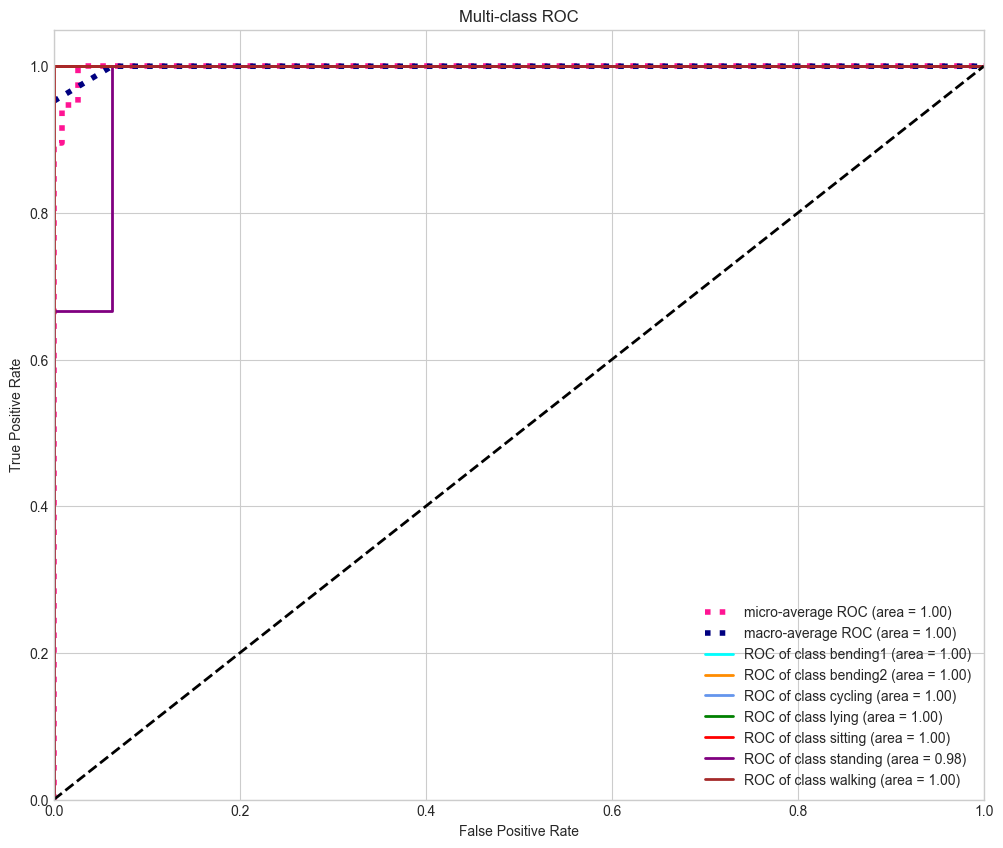

In [ ]:
best_l_multi = -1
best_c_multi = -1
best_score_multi = -1

cv_strategy_multi = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# loop over l
for l in range(1, 21):
    print(f"Testing l = {l} for multi-class...")
    df_train_mc = build_segmented_features(train_files, l=l)
    y_train_mc = df_train_mc['activity']
    X_train_mc = df_train_mc.drop(columns=['activity'])
    
    # check if we have enough classes
    if len(y_train_mc.unique()) < 2:
        print(f"  Skipping l={l} - insufficient classes")
        continue
    
    scaler_mc = StandardScaler()
    X_train_mc_scaled = scaler_mc.fit_transform(X_train_mc)
    
    log_reg_mc = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=5000, tol=0.01)
    param_grid_mc = {'C': np.logspace(-2, 2, 5)}
    
    grid_search_mc = GridSearchCV(log_reg_mc, param_grid_mc, cv=cv_strategy_multi, scoring='accuracy')
    grid_search_mc.fit(X_train_mc_scaled, y_train_mc)
    
    if grid_search_mc.best_score_ > best_score_multi:
        best_score_multi, best_l_multi, best_c_multi = grid_search_mc.best_score_, l, grid_search_mc.best_params_['C']

print(f"\nOptimal (l, C): ({best_l_multi}, {best_c_multi}) with CV Accuracy: {best_score_multi:.4f}")

# build final models
df_train_mc_final = build_segmented_features(train_files, l=best_l_multi)
y_train_mc_final = df_train_mc_final['activity']
X_train_mc_final = df_train_mc_final.drop(columns=['activity'])
final_scaler_mc = StandardScaler().fit(X_train_mc_final)
X_train_mc_scaled = final_scaler_mc.transform(X_train_mc_final)

df_test_mc_final = build_segmented_features(test_files, l=best_l_multi)
y_test_mc_final = df_test_mc_final['activity']
X_test_mc_final = df_test_mc_final.drop(columns=['activity'])
X_test_mc_scaled = final_scaler_mc.transform(X_test_mc_final)

# train final l1 multinomial model
final_mc_model = LogisticRegression(penalty='l1', C=best_c_multi, solver='saga', multi_class='multinomial', max_iter=7000)
final_mc_model.fit(X_train_mc_scaled, y_train_mc_final)

# test the model
y_test_pred_mc = final_mc_model.predict(X_test_mc_scaled)
test_error_mc = 1 - (y_test_pred_mc == y_test_mc_final).mean()
print(f"L1 Multinomial Regression Test Error: {test_error_mc:.4f}")

# confusion matrix
class_labels = sorted(y_train_mc_final.unique())
cm_mc = confusion_matrix(y_test_mc_final, y_test_pred_mc, labels=class_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mc, annot=True, fmt='d', cmap='viridis', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (L1 Multinomial Regression)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# multiclass ROC Curves
y_test_binarized = label_binarize(y_test_mc_final, classes=class_labels)
y_test_proba_mc = final_mc_model.predict_proba(X_test_mc_scaled)
n_classes = len(class_labels)

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_proba_mc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_test_proba_mc.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"], tpr["macro"], roc_auc["macro"] = all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

plt.figure(figsize=(12, 10))
plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC (area = {roc_auc["micro"]:0.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f'macro-average ROC (area = {roc_auc["macro"]:0.2f})', color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC of class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

### Gaussian & Multinomial Naive Bayes


Gaussian NB Test Error: 0.1053


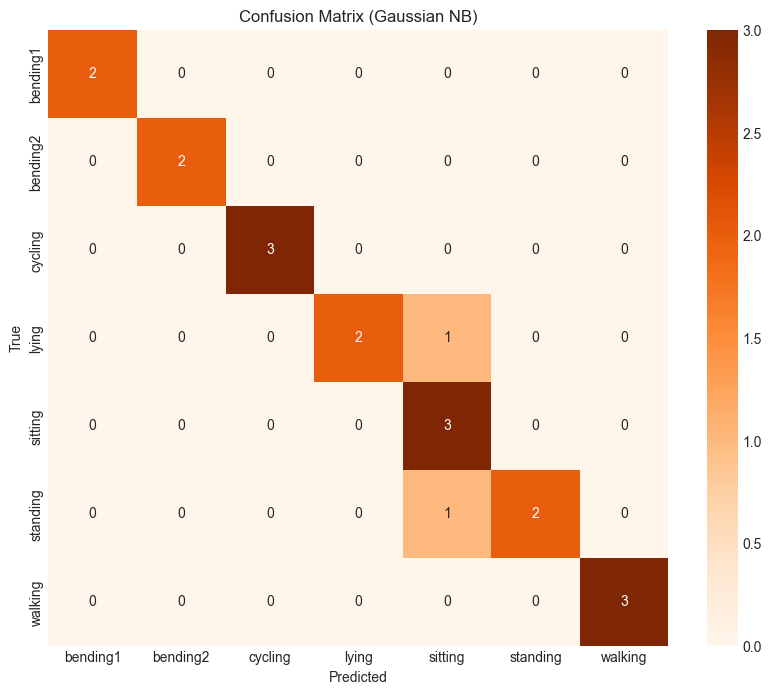

Multinomial NB Test Error: 0.2105


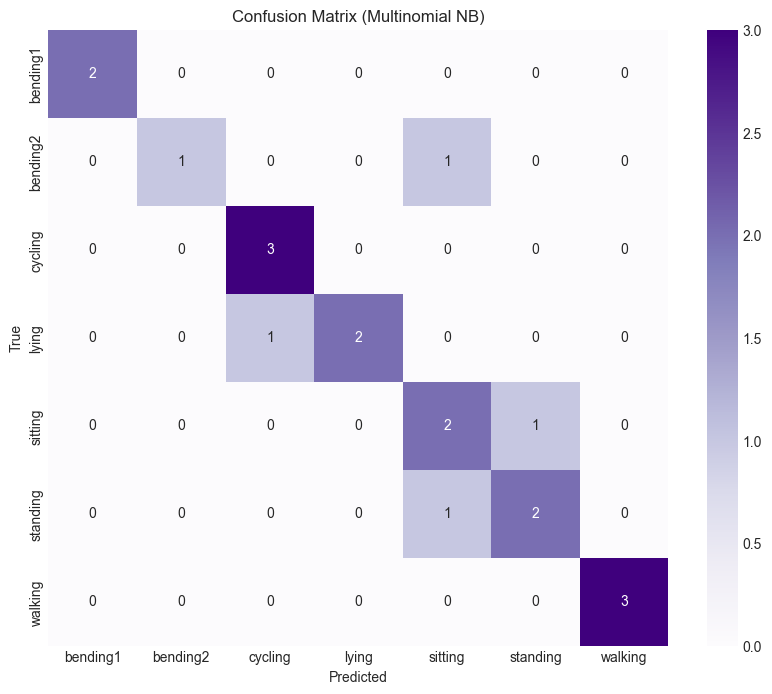

In [15]:
# gaussian naive bayes
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train_mc_scaled, y_train_mc_final)
y_test_pred_gnb = gnb_classifier.predict(X_test_mc_scaled)
test_error_gnb = 1 - (y_test_pred_gnb == y_test_mc_final).mean()
print(f"Gaussian NB Test Error: {test_error_gnb:.4f}")

cm_gnb = confusion_matrix(y_test_mc_final, y_test_pred_gnb, labels=class_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Oranges', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Gaussian NB)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# multinomial naive bayes 
min_max_scaler = MinMaxScaler().fit(X_train_mc_final)
X_train_mc_minmax = min_max_scaler.transform(X_train_mc_final)
X_test_mc_minmax = min_max_scaler.transform(X_test_mc_final)

mnb_classifier = MultinomialNB()
mnb_classifier.fit(X_train_mc_minmax, y_train_mc_final)
y_test_pred_mnb = mnb_classifier.predict(X_test_mc_minmax)
test_error_mnb = 1 - (y_test_pred_mnb == y_test_mc_final).mean()
print(f"Multinomial NB Test Error: {test_error_mnb:.4f}")

cm_mnb = confusion_matrix(y_test_mc_final, y_test_pred_mnb, labels=class_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Multinomial NB)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Model Comparison & Summary


The **L1-penalized multinomial regression and the Gaussian Naïve Bayes models are the best methods**, both performing with a test error of approximately 0.1053.

Between these two, the L1-penalized model could be considered slightly better due to its built-in feature selection and regularization, which often leads to more robust and interpretable models.

The **Multinomial Naïve Bayes classifier performed significantly worse**, as its underlying assumptions about discrete, non-negative features are not a good fit for this dataset.

---
## Summary

| Task | Best approach | Result |
|------|---------------|--------|
| Binary (bending vs. other) | RFE + Logistic Regression, L1-penalized | Perfect / near-perfect test accuracy |
| Multi-class (7 classes) | L1 multinomial, Gaussian NB | ~10% test error |

**Key takeaways:** Mean, max, and standard deviation features discriminate well between activities. Segmented feature extraction (varying *l*) with RFECV finds optimal segment count. L1 regularization provides simpler tuning than RFE for comparable performance.
